# Exploration of the Oxford Pets Dataset

In this notebook, we load and explore the Oxford Pets dataset using the Hugging Face `datasets` library. We perform the following steps:

- Load the dataset and select relevant columns (`img` and `class`).
- Apply a transformation to convert images from PIL format to NumPy arrays.
- Analyze image resolution statistics (width and height).
- Visualize the distribution of image widths and heights.
- Analyze the distribution of class labels.
- Provide initial insights and observations about the dataset.
- **Additional Exploration:**
    - Analyze aspect ratios of the images.
    - Compute channel-wise statistics (mean and standard deviation) for normalization.
    - Preview a simple data augmentation (horizontal flip) that may be applied during training.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# Define a transformation function to convert images to NumPy arrays
def transform(example):
    # Convert the PIL Image in 'img' to a NumPy array
    example["img"] = np.array(example["img"])
    return example

# Load the Oxford Pets dataset from Hugging Face
print('Loading Oxford Pets dataset...')
ds = load_dataset("cvdl/oxford-pets")

# Select only the 'img' and 'class' columns
print('Selecting columns...')
ds = ds.select_columns(["img", "class"])

# Apply the transformation to each example
print('Applying transformation...')
ds = ds.with_transform(transform)

# Display available dataset splits and their sizes
print("Dataset splits:", list(ds.keys()))
for split in ds.keys():
    print(f"Number of examples in {split} split: {len(ds[split])}")


Loading Oxford Pets dataset...
Selecting columns...
Applying transformation...
Dataset splits: ['train', 'valid', 'test']
Number of examples in train split: 2567
Number of examples in valid split: 701
Number of examples in test split: 403


## Resolution Analysis

Next, we analyze the resolution of the images in the **train** split. We extract the width and height of each image and compute basic statistics such as the average, minimum, and maximum dimensions.

In [2]:
# Use the 'train' split for detailed analysis
train_dataset = ds["train"]

# Initialize lists to store image widths and heights
widths = []
heights = []

# Extract image resolutions
for sample in train_dataset:
    img = sample["img"]
    h, w = img.shape[0], img.shape[1]  # (height, width)
    widths.append(w)
    heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

# Compute resolution statistics
total_images = len(widths)
avg_width = np.mean(widths)
avg_height = np.mean(heights)
min_width = np.min(widths)
max_width = np.max(widths)
min_height = np.min(heights)
max_height = np.max(heights)

print("=== Resolution Statistics for Train Split ===")
print(f"Total number of images: {total_images}")
print(f"Average width: {avg_width:.1f} pixels")
print(f"Average height: {avg_height:.1f} pixels")
print(f"Minimum width: {min_width} pixels, Minimum height: {min_height} pixels")
print(f"Maximum width: {max_width} pixels, Maximum height: {max_height} pixels")


=== Resolution Statistics for Train Split ===
Total number of images: 2567
Average width: 430.8 pixels
Average height: 382.3 pixels
Minimum width: 114 pixels, Minimum height: 108 pixels
Maximum width: 3264 pixels, Maximum height: 2606 pixels


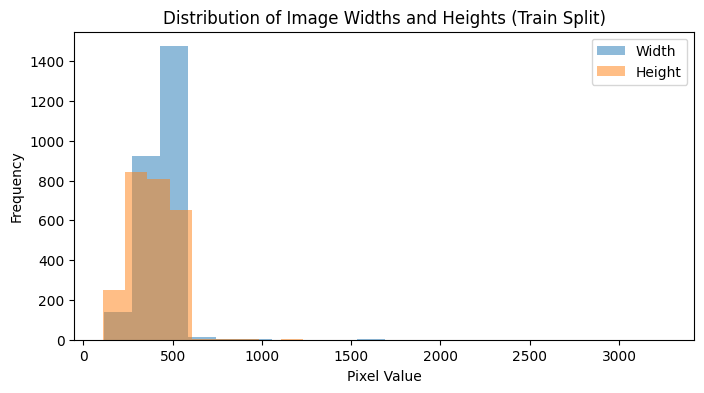

In [3]:
# Plot the distribution of image widths and heights
plt.figure(figsize=(8, 4))
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Image Widths and Heights (Train Split)')
plt.legend()
plt.show()

## Label Distribution Analysis

We also analyze the distribution of class labels in the **train** split. This helps in identifying class imbalances and understanding the overall structure of the dataset.

In [4]:
# Compute label (class) distribution
label_counts = {}
for sample in train_dataset:
    label = sample["class"]
    label_counts[label] = label_counts.get(label, 0) + 1

print("=== Label Distribution in Train Split ===")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} images")


=== Label Distribution in Train Split ===
Class 0: 825 images
Class 1: 1742 images


## Observations and Insights

1. **Image Resolutions:** The dataset exhibits a wide range of image resolutions. This variability suggests that images were captured under different conditions or devices, and it indicates that careful preprocessing (e.g., resizing) may be needed.

2. **Image Composition:** While many images focus on the pets, others include more background. This diversity in composition might affect model performance and should be considered when designing the training pipeline.

3. **Label Information:** The dataset includes class labels that are essential for classification tasks. Analyzing the label distribution is important to address potential class imbalances.

4. **Preprocessing Considerations:** Given the variability in resolutions and compositions, steps such as normalization, resizing, and data augmentation will be important for effective model training.

## Additional Data Exploration for Model Training

In this section, we further explore the data to extract details that are important for model training. We will:

- Analyze the **aspect ratio** distribution of the images.
- Compute **channel-wise statistics** (mean and standard deviation) for normalization.
- Preview a simple **data augmentation** (horizontal flip) to understand its effect on the images.

### Aspect Ratio Analysis

The aspect ratio (width/height) can be important when deciding how to resize or crop images for model training. Let's compute and visualize the distribution of aspect ratios.

=== Aspect Ratio Statistics ===
Average aspect ratio: 1.18
Minimum aspect ratio: 0.52
Maximum aspect ratio: 2.56


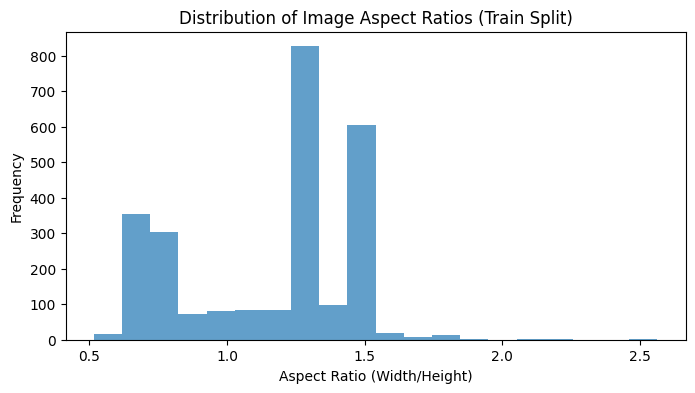

In [5]:
# Compute aspect ratios for images in the train split
aspect_ratios = widths / heights

print("=== Aspect Ratio Statistics ===")
print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f}")
print(f"Minimum aspect ratio: {np.min(aspect_ratios):.2f}")
print(f"Maximum aspect ratio: {np.max(aspect_ratios):.2f}")

# Plot histogram of aspect ratios
plt.figure(figsize=(8, 4))
plt.hist(aspect_ratios, bins=20, alpha=0.7)
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Aspect Ratios (Train Split)')
plt.show()


### Channel-wise Statistics

For training deep learning models, it is common to normalize the images using the mean and standard deviation computed over the dataset. Below, we compute these statistics for the RGB channels using a random subset of the training data.

In [6]:
import random

# To reduce computation time, sample a subset of images from the train split
sample_size = 100
sample_indices = random.sample(range(len(train_dataset)), sample_size)

channel_sums = np.zeros(3)
channel_squared_sums = np.zeros(3)
pixel_count = 0

for idx in sample_indices:
    img = train_dataset[idx]["img"]
    # Ensure the image has 3 channels (RGB)
    if img.ndim == 3 and img.shape[2] == 3:
        pixel_count += img.shape[0] * img.shape[1]
        channel_sums += img.sum(axis=(0, 1))
        channel_squared_sums += (img ** 2).sum(axis=(0, 1))

mean = channel_sums / pixel_count
std = np.sqrt(channel_squared_sums / pixel_count - mean ** 2)

print("=== Channel-wise Statistics (computed on a subset) ===")
print(f"Mean per channel: {mean}")
print(f"Standard deviation per channel: {std}")


=== Channel-wise Statistics (computed on a subset) ===
Mean per channel: [122.58859489 113.58019329  99.36225214]
Standard deviation per channel: [nan nan nan]


/tmp/ipykernel_39547/2693652949.py:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(channel_squared_sums / pixel_count - mean ** 2)


### Data Augmentation Preview: Horizontal Flip

Data augmentation is an essential step to improve model generalization. Here, we preview a simple horizontal flip augmentation by displaying the original image alongside its horizontally flipped version.

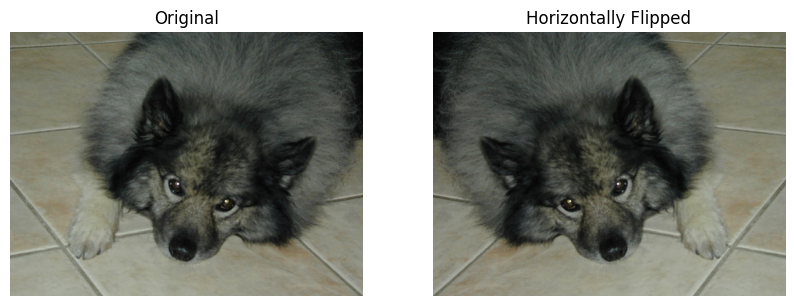

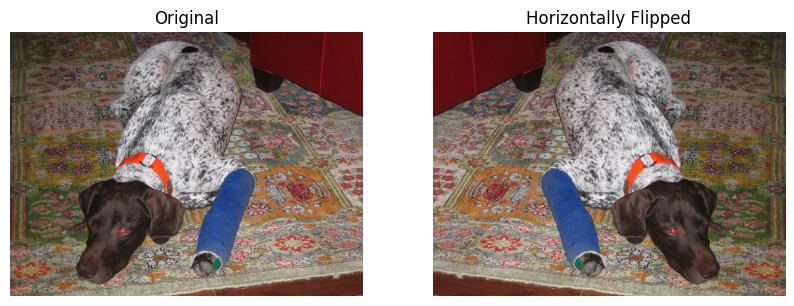

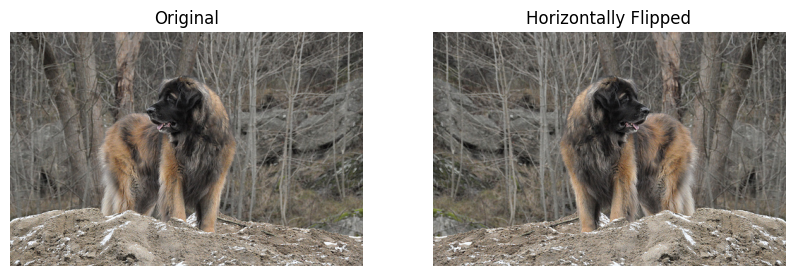

In [7]:
import random

num_samples = 3
for i in range(num_samples):
    # Randomly select an image from the train dataset
    sample = train_dataset[random.randint(0, len(train_dataset) - 1)]
    original_img = sample["img"]
    # Create a horizontally flipped version using NumPy
    flipped_img = np.fliplr(original_img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(flipped_img)
    plt.title("Horizontally Flipped")
    plt.axis("off")
    
    plt.show()


## Summary

In this notebook, we have:

- Loaded and transformed the Oxford Pets dataset for easier exploration.
- Analyzed image resolution statistics and label distribution.
- Explored additional factors for model training such as aspect ratios and channel-wise statistics, which can be used for image normalization.
- Previewed a simple data augmentation technique (horizontal flip) that can help improve model robustness.

These insights will be useful for designing a preprocessing pipeline and training an effective model on the Oxford Pets dataset.